In [1]:
from typing import Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True


config_code_dict = {
    "a": {"fotomultiplicador": False, "laser power": False, "laser light": False},
    "b": {"fotomultiplicador": True, "laser power": False, "laser light": False},
    "c": {"fotomultiplicador": True, "laser power": True, "laser light": False},
    "d": {"fotomultiplicador": True, "laser power": True, "laser light": True},
}

In [50]:
def plot_projected_dist(x: np.ndarray, y: np.ndarray,
                        dx: np.ndarray, dy: np.ndarray,
                        bins: np.ndarray, density: bool = False,
                        fmt: str = ".", fig: Union[plt.figure, None] = None):
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
        fig.set_size_inches((8, 3.5))
        axs[0].set_xlabel("Tiempo [ms]")
        axs[0].set_ylabel("Tensión [mV]")
    else:
        axs = fig.axes
    
    axs[0].errorbar(x=x, xerr=dx,
                    y=y, yerr=dy,
                    fmt=fmt, ms=6,
                    ecolor="k", capsize=2,
                    alpha=0.5, zorder=10)
    axs[1].hist(x=y, bins=bins, orientation="horizontal", density=density,
                histtype="step", lw=1.5, alpha=0.7, zorder=10)
    
    return fig, axs


def plot_measurements(tiempo: np.ndarray,
                      channel: np.ndarray,
                      min_val: float,
                      max_val: float,
                      med_index: int = 0,
                      n_datos: int = 2000,
                      fig: Union[plt.figure, None] = None,
                      density: bool = False,
                      ) -> tuple[plt.figure, list[plt.axes]]:
    """"""
    t = tiempo[med_index*n_datos:(med_index + 1)*n_datos]
    ch = channel[med_index*n_datos:(med_index + 1)*n_datos]
    
    temp_res = 1/250e3  # s
    volt_res = 1.05*(max_val - min_val)/(2**16)  # V
    
    x = (t - t[0])*1e3  # ms
    dx = temp_res*1e3/2  # ms
    y = ch*1e3  # mV
    dy = volt_res*1e3/2  # mV
    
    bin_range = np.arange(min_val*1e3, max_val*1e3, 2)  # mV
    bins = bin_range[(y.max() + 2 >= bin_range) & (y.min() - 2 <= bin_range)]
    if n_datos < 200:
        fig, axs = plot_projected_dist(x, y, dx, dy, bins, density, ".-", fig)
    else:
        fig, axs = plot_projected_dist(x, y, dx, dy, bins, density, ".", fig)
    
    return fig, axs


def get_peaks(tiempo, channel, window_size):
    t = np.reshape(tiempo, (-1, window_size))
    ch = np.reshape(channel, (-1, window_size))
    min_ids = ch.argmin(axis=1, keepdims=True)
    t = np.take_along_axis(t, min_ids, axis=1).flatten()
    ch = np.take_along_axis(ch, min_ids, axis=1).flatten()
    return t, ch


def plot_custom_peaks(tiempo: np.ndarray,
                      channel: np.ndarray,
                      min_val: float,
                      max_val: float,
                      med_index: int = 0,
                      n_datos: int = 2000,
                      fig: Union[plt.figure, None] = None,
                      density: bool = False,
                      window_size: int = 10
                      ) -> tuple[plt.figure, list[plt.axes]]:
    """"""
    t = tiempo[med_index*n_datos:(med_index + 1)*n_datos]
    ch = channel[med_index*n_datos:(med_index + 1)*n_datos]
    t_p, ch_p = get_peaks(t, ch, window_size)
    
    temp_res = 1/250e3  # s
    volt_res = 1.05*(max_val - min_val)/(2**16)  # V
    
    x = (t_p - t[0])*1e3  # ms
    dx = temp_res*1e3/2  # ms
    y = ch_p*1e3  # mV
    dy = volt_res*1e3/2  # mV
    
    bin_range = np.arange(min_val*1e3, max_val*1e3, 2)  # mV
    bins = bin_range[(y.max() + 2 >= bin_range) & (y.min() - 2 <= bin_range)]
    fig, axs = plot_projected_dist(x, y, dx, dy, bins, density, "v", fig)
    
    return fig, axs

## Una Señal DAQ

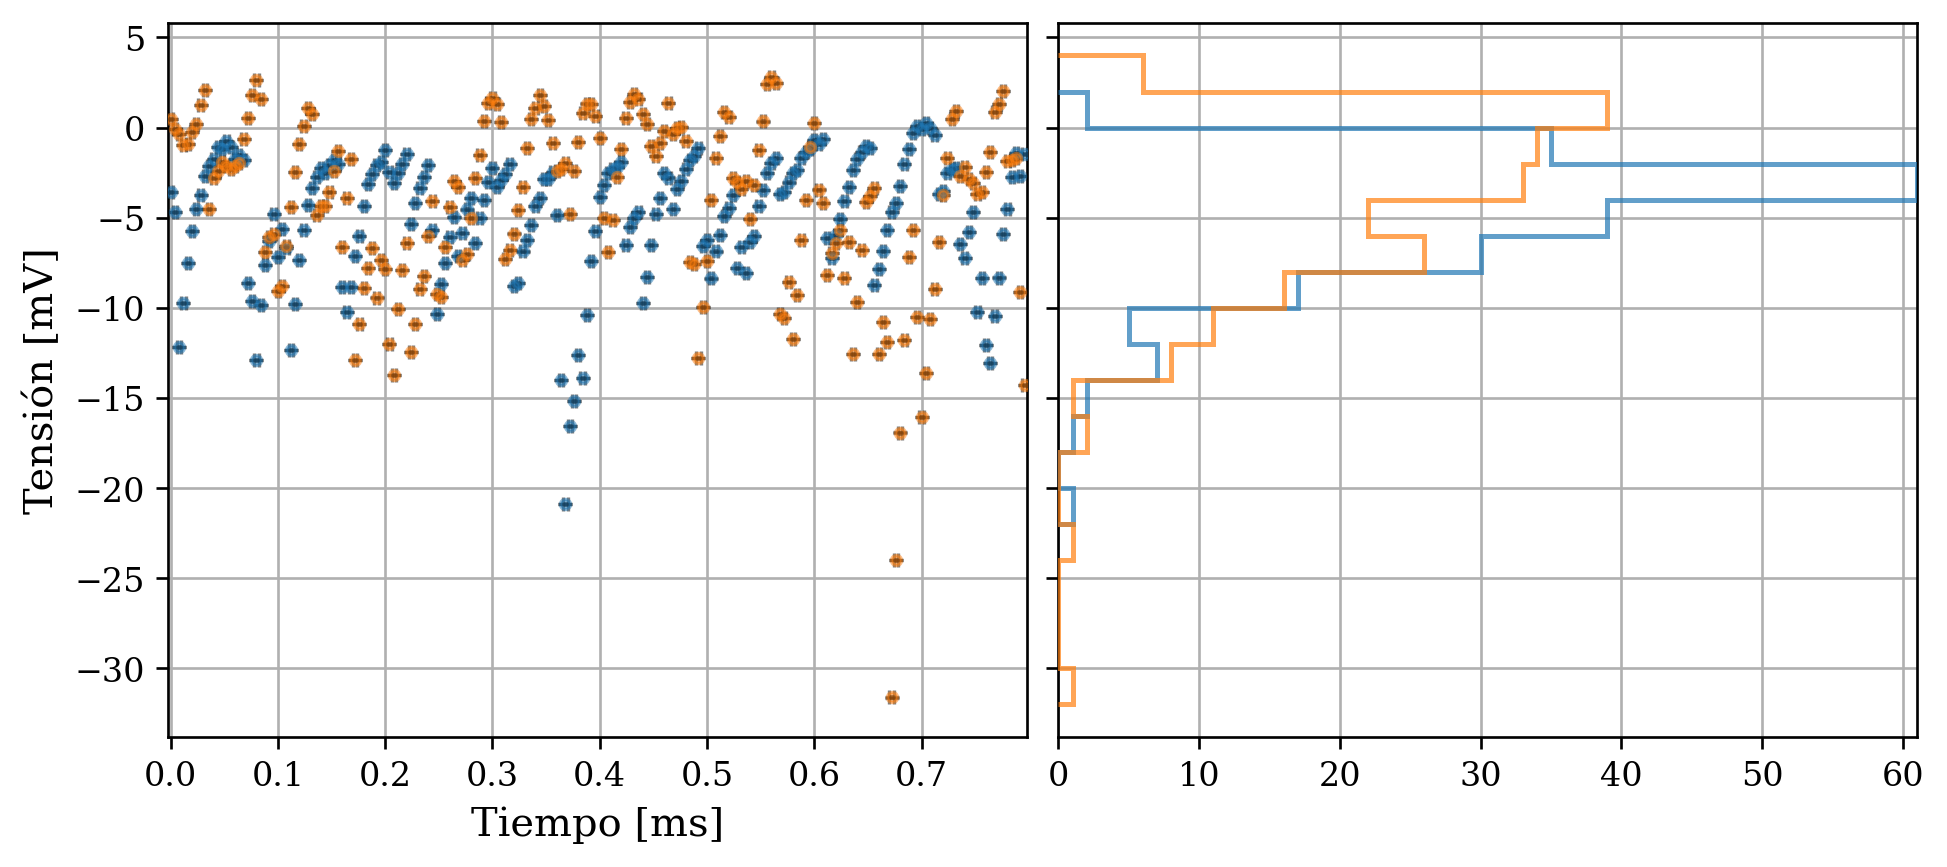

In [51]:
# Leer una tanda guardada:
config = "d"  # Estado del instrumental al medir
tension = 1050  # Tensión en la fuente del fotomultiplicador
angulo = 230  # Ángulo relativo entre polarizadores a la salida del láser
freq = 250e3  # Hz
max_val = 50e-3  # V
min_val = -150e-3  # V
modo = "sample"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
tiempo, channel = np.load(f"DAQ_10s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                           + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V

# Ploteando de a cachos
fig, axs = plot_measurements(tiempo, channel, min_val, max_val, med_index=0, n_datos=200)
plot_measurements(tiempo, channel, min_val, max_val, med_index=6, n_datos=200, fig=fig)
plt.show()

In [41]:
5/250e3*1e6

20.0

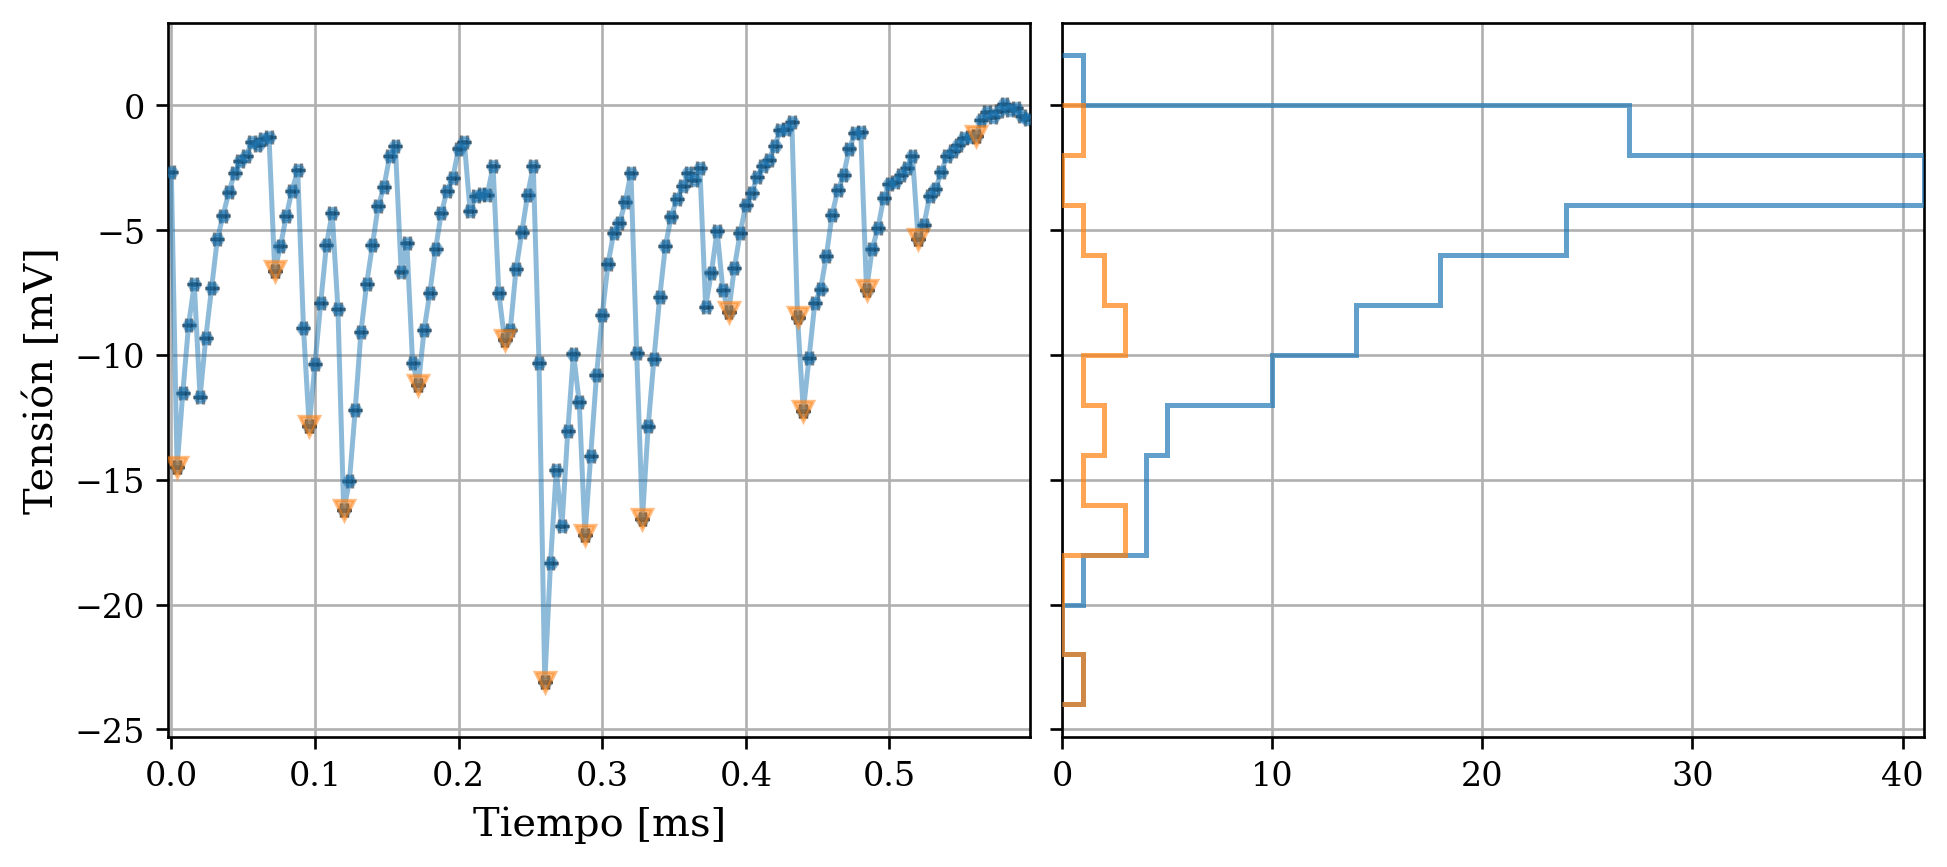

In [54]:
w_size = 10  # Window size in data points
n_datos = 150
med_index = 2
plot_args = tiempo, channel, min_val, max_val, med_index, n_datos
fig, axs = plot_measurements(*plot_args)
plot_custom_peaks(*plot_args, fig, window_size=w_size)
plt.show()